Here we explore `SDXL` one of the most popular image generation models provided by Stability AI. We can find more information [here](https://huggingface.co/stabilityai/stable-diffusion-xl-base-1.0)

## Setting up Colab Environment

1. Change runtime type to GPU (from CPU).

```
Runtime > Change runtime type > Setting the Hardware accelerator to GPU > Save
```


2. If we need to use the cuda, we have to have cuda tookit. The Google Colab has already installed that. We can use the following code to verify that.


In [ ]:
!ls /usr/local/

bin    cuda	cuda-12.2  games	       include	lib64	   man	 share
colab  cuda-12	etc	   _gcs_config_ops.so  lib	licensing  sbin  src



3. Then, we need to verify if the nvcc command is there in the $PATH environment to use.


In [ ]:
!which nvcc

/usr/local/cuda/bin/nvcc




4. Check the cuda driver. The Google Colab also has already installed that. We can use the following code to verify that.

In [ ]:
!nvidia-smi

Tue Dec 19 08:51:17 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Preprocessing
Make sure to upgrade diffusers to >= 0.19.0

In [1]:
!pip install diffusers --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 8.2 MB/s eta 0:00:00


In [2]:
!pip install invisible_watermark transformers accelerate safetensors

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 13.8 MB/s eta 0:00:00


## Base Model

In [ ]:
from diffusers import DiffusionPipeline
import torch

pipe = DiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0",
                                         torch_dtype=torch.float16,
                                         use_safetensors=True, variant="fp16")

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

model_index.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

Fetching 19 files:   0%|          | 0/19 [00:00<?, ?it/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

text_encoder_2/config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer_2/tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

tokenizer_2/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.68k [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

tokenizer_2/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/5.14G [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

## Cuda
We perform inference using cuda.

In [ ]:
pipe.to("cuda")

# if using torch < 2.0
# pipe.enable_xformers_memory_efficient_attention()
torch.__version__

prompt = "An astronaut riding a green horse"

images = pipe(prompt=prompt).images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

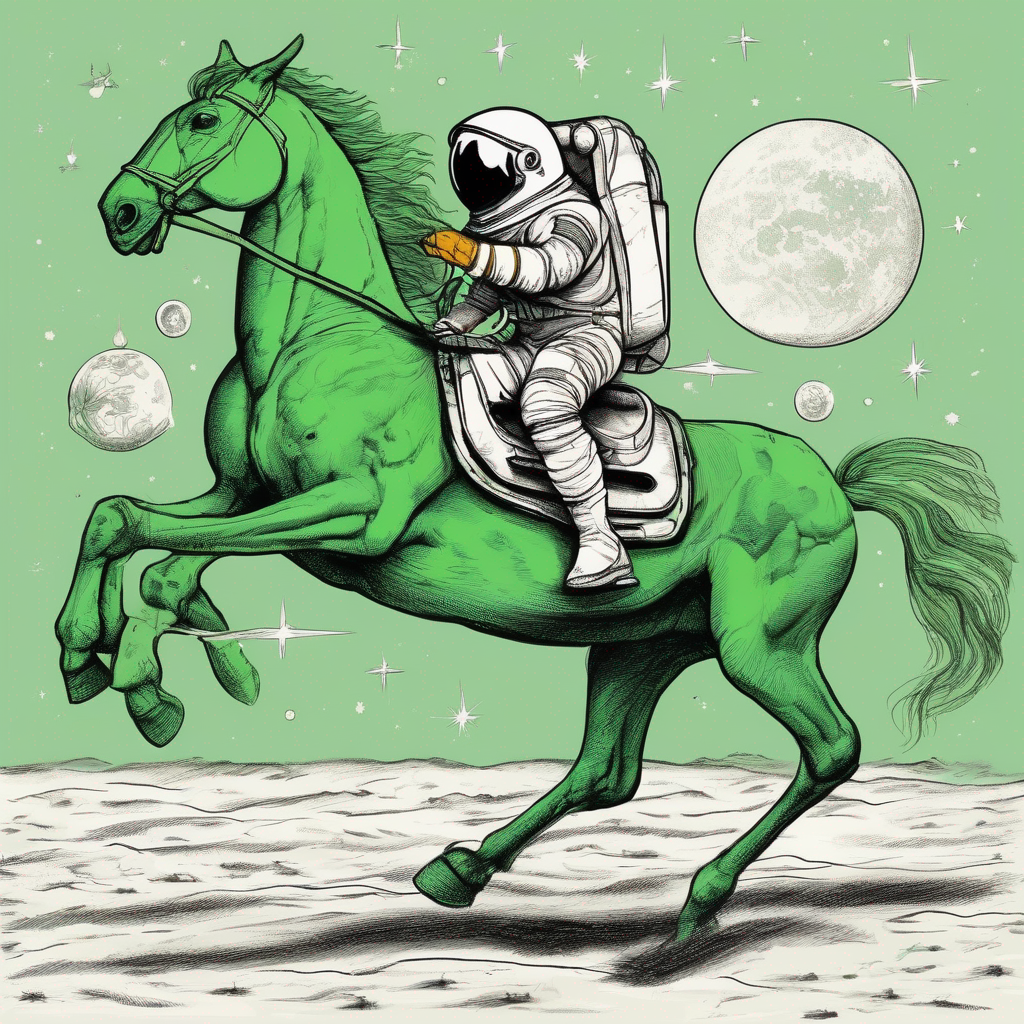

In [ ]:
images

## Base + Refiner
The base model generates (noisy) `latents`, which are then further processed with a refinement model specialized for the final denoising steps

In [5]:
from diffusers import DiffusionPipeline
import torch

# load both base & refiner
base = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16, variant="fp16", use_safetensors=True
)
base.to("cuda")
refiner = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-refiner-1.0",
    text_encoder_2=base.text_encoder_2,
    vae=base.vae,
    torch_dtype=torch.float16,
    use_safetensors=True,
    variant="fp16",
)
refiner.to("cuda")

# Define how many steps and what % of steps to be run on each experts (80/20) here
n_steps = 40
high_noise_frac = 0.8

prompt = "A majestic lion jumping from a big stone at night"

# run both experts
image = base(
    prompt=prompt,
    num_inference_steps=n_steps,
    denoising_end=high_noise_frac,
    output_type="latent",
).images
image = refiner(
    prompt=prompt,
    num_inference_steps=n_steps,
    denoising_start=high_noise_frac,
    image=image,
).images[0]


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

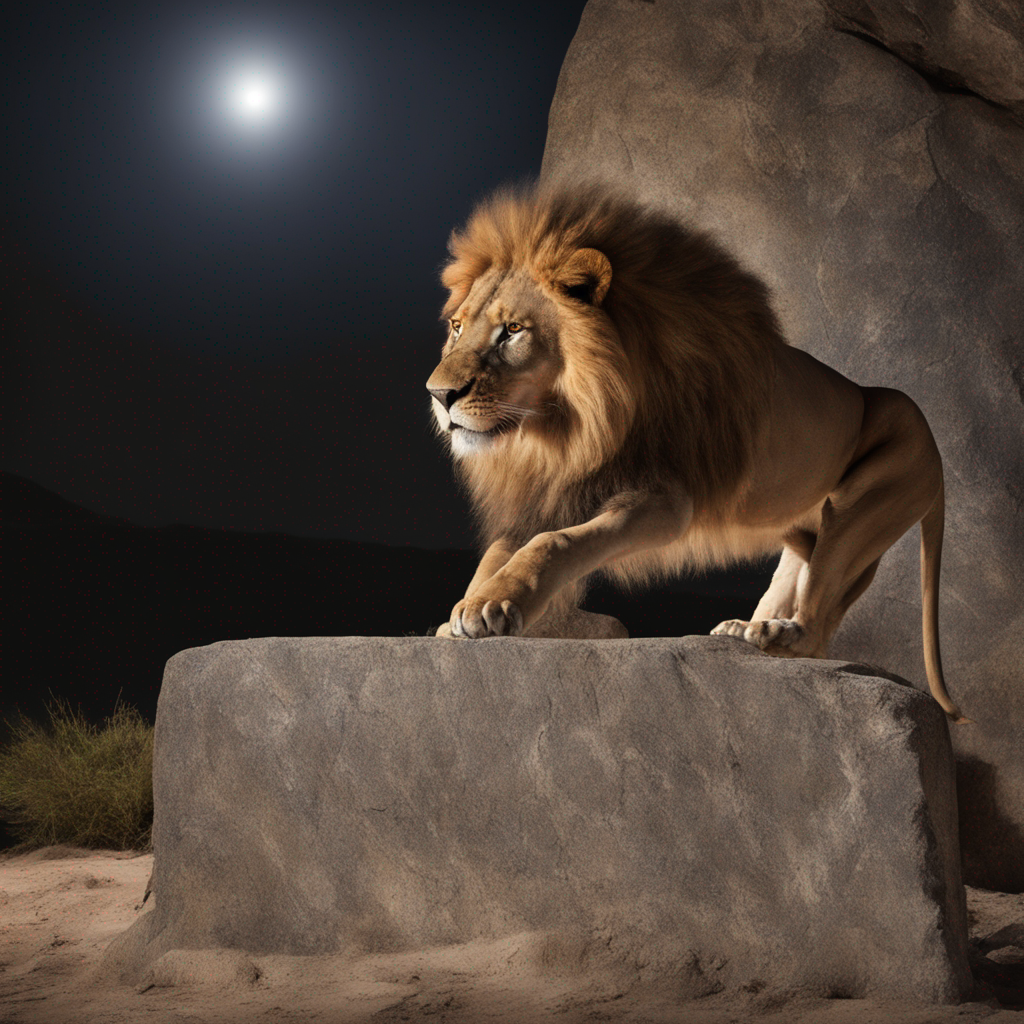

In [6]:
image